In [1]:
!pip install fastprogress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab/ethnicolor/

/content/drive/MyDrive/Colab/ethnicolor


In [4]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.Tensor([0.0]).to(device)

tensor([0.], device='cuda:0')

## Data preprocessing

In [6]:
train_df = pd.read_csv("data/fl_2022_LastName_train.csv.gz")
val_df = pd.read_csv("data/fl_2022_LastName_val.csv.gz")
test_df = pd.read_csv("data/fl_2022_LastName_test.csv.gz")

In [7]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1079199, 4)
(134900, 4)
(134900, 4)


In [8]:
gen_df = pd.read_csv("data/fl_2022_LastName_train_with_gen.csv")

In [9]:
gen_df.shape

(1209093, 3)

In [10]:
train_df.head()

,name_last,name_first,race,race_code
0,Olivier-White,Jean,hispanic,3
1,Menkhorst,Erwin,nh_white,2
2,Mosquera Cubillos,Catalina,hispanic,3
3,Coste,Charles,nh_white,2
4,Jimenez De Los Santo,Rosa,hispanic,3


In [11]:
gen_df.head()

,name_last,race,race_code
0,Baxla,nh_white,0
1,Ludwin,nh_white,0
2,Signer Welton,nh_white,0
3,Stamps,nh_white,0
4,Vassell,nh_black,1


In [12]:
gen_df['name_last'] = gen_df['name_last'].str.replace("[^a-zA-Z' -]", '', regex=True)

In [13]:
gen_df = gen_df.dropna()

In [14]:
gen_df = gen_df.drop(gen_df[gen_df['name_last'].str.len() < 2].index)

In [15]:
train_df = gen_df[list(gen_df.columns)]
val_df = val_df[list(gen_df.columns)]
test_df = test_df[list(gen_df.columns)]

In [16]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1208711, 3)
(134900, 3)
(134900, 3)


In [17]:
train_df['name_last'] = train_df['name_last'].str.title()
val_df['name_last'] = val_df['name_last'].str.title()
test_df['name_last'] = test_df['name_last'].str.title()

In [18]:
train_df.head()

,name_last,race,race_code
0,Baxla,nh_white,0
1,Ludwin,nh_white,0
2,Signer Welton,nh_white,0
3,Stamps,nh_white,0
4,Vassell,nh_black,1


## Creating Dataset

In [19]:
all_letters = string.ascii_letters + "'- "

In [20]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'- "

In [21]:
n_letters = len(all_letters)

In [22]:
n_letters

55

In [74]:
val_df.head()

,name_last,race,race_code
0,Shehadi,nh_white,2
1,Ruiz-Sganga,hispanic,3
2,Holiday Henry,nh_white,2
3,Pansara,nh_white,2
4,Malakoff,asian,4


In [75]:
test_df.head()

,name_last,race,race_code
0,Detringo,nh_white,2
1,Mcneil-Collins,other,0
2,Solanky,asian,4
3,Monserrate Santos,hispanic,3
4,Yandoc,nh_white,2


In [25]:
# train with gen has different race_codes since this was taken from fullname dataset
# so we need to sync with val and test df
train_df.head()

,name_last,race,race_code
0,Baxla,nh_white,0
1,Ludwin,nh_white,0
2,Signer Welton,nh_white,0
3,Stamps,nh_white,0
4,Vassell,nh_black,1


In [82]:
# get mappings from val_df
race_id_df = val_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [83]:
id_to_race

{0: 'other', 1: 'nh_black', 2: 'nh_white', 3: 'hispanic', 4: 'asian'}

In [84]:
race_to_id

{'other': 0, 'nh_black': 1, 'nh_white': 2, 'hispanic': 3, 'asian': 4}

In [85]:
# sync train_df, so the outputs match with val and test df
train_df['race_code'] = train_df['race'].apply(lambda x: race_to_id[x])

In [86]:
train_df.head()

,name_last,race,race_code
0,Baxla,nh_white,2
1,Ludwin,nh_white,2
2,Signer Welton,nh_white,2
3,Stamps,nh_white,2
4,Vassell,nh_black,1


In [87]:
train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')

,race,race_code
39,other,0
4,nh_black,1
0,nh_white,2
5,hispanic,3
14,asian,4


In [88]:
all_categories = list(id_to_race.values())

In [89]:
all_categories

['other', 'nh_black', 'nh_white', 'hispanic', 'asian']

In [90]:
n_categories = len(train_df['race_code'].unique())

In [91]:
n_categories

5

In [92]:
max_name = int(train_df['name_last'].str.len().max())

In [93]:
max_name

30

In [94]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [95]:
letterToIndex(' ')

54

In [96]:
oob = n_letters + 1

In [97]:
oob

56

In [98]:
tensor = torch.ones(max_name) * oob

In [99]:
def lineToTensor(line):
    tensor = torch.ones(max_name) * oob
    try:
      for li, letter in enumerate(line):
          tensor[li] = letterToIndex(letter)
    except:
      print("line: ", line)
    return tensor

In [100]:
lineToTensor('Jason')

tensor([35.,  0., 18., 14., 13., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])

In [101]:
print(lineToTensor('Jason').size())

torch.Size([30])


In [102]:
train_df.head()

,name_last,race,race_code
0,Baxla,nh_white,2
1,Ludwin,nh_white,2
2,Signer Welton,nh_white,2
3,Stamps,nh_white,2
4,Vassell,nh_black,1


In [103]:
train_df.iloc[0, 2]

2

In [104]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, 0]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, 2]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [105]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [106]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([27.,  0., 23., 11.,  0., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.]) tensor(2)
1 tensor([37., 20.,  3., 22.,  8., 13., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.]) tensor(2)
2 tensor([44.,  8.,  6., 13.,  4., 17., 54., 48.,  4., 11., 19., 14., 13., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.]) tensor(2)


In [107]:
# The Dataset retrieves our dataset’s features and labels one sample at a time.
# While training a model, we typically want to pass samples in “minibatches”,
# reshuffle the data at every epoch to reduce model overfitting, and
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)

In [108]:
next(iter(train_dataloader))

[tensor([[28.,  0.,  8.,  ..., 56., 56., 56.],
         [28., 14., 11.,  ..., 56., 56., 56.],
         [38.,  4.,  9.,  ..., 56., 56., 56.],
         ...,
         [39.,  8.,  4.,  ..., 56., 56., 56.],
         [28., 14., 18.,  ..., 56., 56., 56.],
         [38.,  8., 11.,  ..., 56., 56., 56.]]),
 tensor([2, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 3, 0, 4, 2, 1, 3, 2, 2, 2, 2, 2, 0, 1,
         3, 2, 2, 0, 2, 2, 3, 4, 2, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 2, 3, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 0, 4, 2, 2, 3, 2, 2, 2, 3, 3, 3, 1, 2, 3, 2, 2, 2,
         2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 1, 3, 2, 1, 2, 2, 0, 3, 1, 1,
         3, 0, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2,
         3, 3, 3, 3, 1, 2, 2, 2])]

In [109]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 30]) torch.Size([128])
1 torch.Size([128, 30]) torch.Size([128])
2 torch.Size([128, 30]) torch.Size([128])


In [110]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [111]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        # self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        # out = self.dropout(out) # Non-linear regularization
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name
vocab_size = n_letters + 2

rnn = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
rnn.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [112]:
input = lineToTensor('Rogers Renee')

print(input)
print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = rnn(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)

tensor([43., 14.,  6.,  4., 17., 18., 54., 43.,  4., 13.,  4.,  4., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
input shape :  torch.Size([30])
input shape w batch :  torch.Size([1, 30])
torch.Size([1, 5])


In [113]:
output

tensor([[-1.6286, -1.6088, -1.6173, -1.5791, -1.6141]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [114]:
torch.argmax(output)

tensor(3, device='cuda:0')

In [115]:
a = torch.zeros(1, 2, 3, 4, 5, 6)
b = a.view(*a.shape[:2], -1, *a.shape[5:])
print(a.shape)
print(b.shape)

torch.Size([1, 2, 3, 4, 5, 6])
torch.Size([1, 2, 60, 6])


In [116]:
a = torch.zeros(1,47,53,64)
b = a.view(a.shape[0],-1,a.shape[3])
print(a.shape)
print(b.shape)
c = torch.zeros([1, 2491, 256])
d = c.view(c.shape[0],47,53,c.shape[2])
print(d.shape)

torch.Size([1, 47, 53, 64])
torch.Size([1, 2491, 64])
torch.Size([1, 47, 53, 256])


In [117]:
top_n, top_i = output.topk(1)

In [118]:
output

tensor([[-1.6286, -1.6088, -1.6173, -1.5791, -1.6141]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [119]:
top_n

tensor([[-1.5791]], device='cuda:0', grad_fn=<TopkBackward0>)

In [120]:
top_n # has log values
top_i # has indices

tensor([[3]], device='cuda:0')

In [121]:
# to get best value
top_n, top_i = output.topk(1)
category_i = top_i[0].item()
all_categories[category_i], category_i

('hispanic', 3)

## Training


In [122]:
device

device(type='cuda', index=0)

In [123]:
!lscpu | grep -i cpu

CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          12
On-line CPU(s) list:             0-11
CPU family:                      6
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
CPU MHz:                         2200.144
NUMA node0 CPU(s):               0-11
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities


In [124]:
!nvidia-smi

Sun Jun 18 00:58:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |   1529MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [125]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

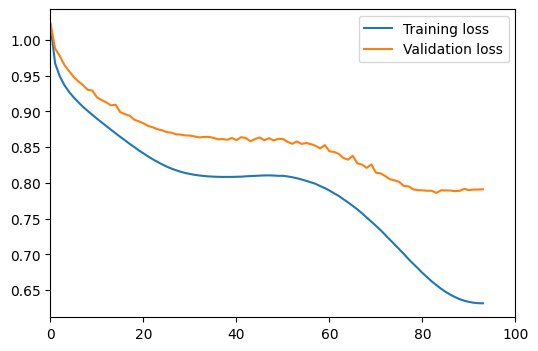

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 1.023197).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (1.023197 --> 0.987762).  Saving model ...
Validation loss decreased (0.987762 --> 0.977539).  Saving model ...
Validation loss decreased (0.977539 --> 0.964781).  Saving model ...
Validation loss decreased (0.964781 --> 0.956339).  Saving model ...
Validation loss decreased (0.956339 --> 0.948128).  Saving model ...
Validation loss decreased (0.948128 --> 0.941846).  Saving model ...
Validation loss decreased (0.941846 --> 0.936735).  Saving model ...
Validation loss decreased (0.936735 --> 0.930208).  Saving model ...
Validation loss decreased (0.930208 --> 0.929102).  Saving model ...
Validation loss decreased (0.929102 --> 0.919703).  Saving model ...
Validation loss decreased (0.919703 --> 0.915861).  Saving model ...
Validation loss decreased (0.915861 --> 0.912627).  Saving model ...
Validation loss decreased (0.912627 --> 0.908419).  Saving model ...
Validation loss decreased (0.908419 --> 0.899008).  Saving model ...
Validation loss decreased (0.89900

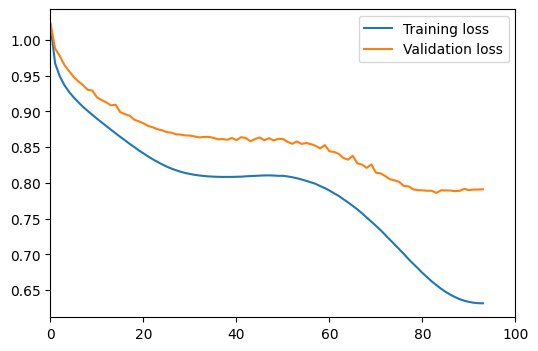

In [126]:
epochs = 100
lr = 0.0001 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model
criterion = nn.NLLLoss()

# applying L2 regularization using weight_decay,
# optimizer = AdamW(rnn.parameters(), lr, weight_decay=0.01)
optimizer = AdamW(rnn.parameters(), lr)

# l1 regularization
lambda_l1 = 0.0001

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)


early_stopper = EarlyStopper(patience=10)


mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 1000

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  rnn.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    rnn.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)

    # Calculate L1 regularization
    #l1_regularization = 0
    #for param in rnn.parameters():
    #    l1_regularization += torch.norm(param, 1)

    # Add L1 regularization to the loss.
    #loss = loss + lambda_l1 * l1_regularization

    # backward propagation
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    #torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  rnn.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = rnn(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch
  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(rnn.state_dict(), 'lstm_LastName_pytorch_gen.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):
      break

## Save Model

In [127]:
torch.save(rnn.state_dict(), 'lstm_LastName_pytorch_after_train_gen.pt')

Text(0, 0.5, 'loss')

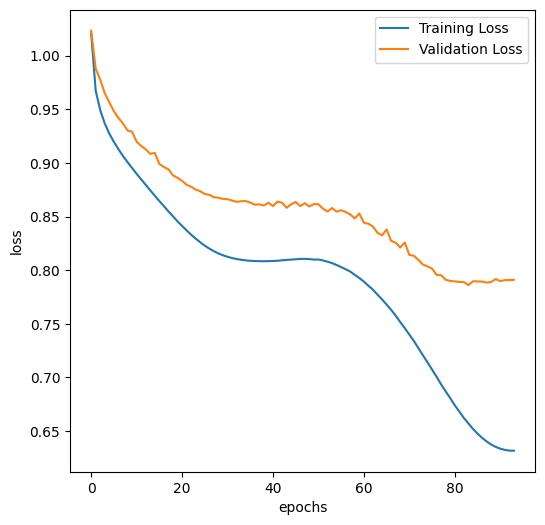

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, training_losses, validation_losses)
ax.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("epochs")
plt.ylabel("loss")

In [129]:
# last epoch losses
print(training_losses[-1])
print(validation_losses[-1])

tensor([0.6317])
tensor([0.7910])


In [65]:
rnn.load_state_dict(torch.load('lstm_LastName_pytorch_gen.pt'))

<All keys matched successfully>

In [68]:
criterion = nn.NLLLoss()

## Testing

In [130]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [131]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing: 100%|██████████| 1053/1053 [00:19<00:00, 54.25it/s]


              precision    recall  f1-score   support

       asian       0.55      0.35      0.43      6865
    hispanic       0.87      0.74      0.80     38925
    nh_black       0.73      0.60      0.66     13711
    nh_white       0.67      0.92      0.78     60924
       other       0.55      0.11      0.18     14359

    accuracy                           0.72    134784
   macro avg       0.68      0.54      0.57    134784
weighted avg       0.72      0.72      0.69    134784



In [132]:
test_loss/len(test_dataloader)

0.7918405035848518

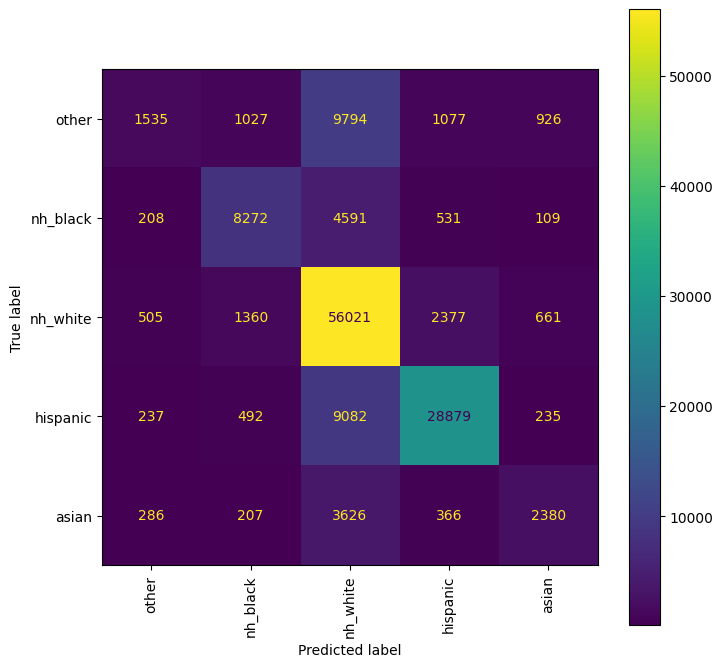

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [134]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.791841

Test Accuracy of other: 10% (1535/14359)
Test Accuracy of nh_black: 60% (8272/13711)
Test Accuracy of nh_white: 91% (56021/60924)
Test Accuracy of hispanic: 74% (28879/38925)
Test Accuracy of asian: 34% (2380/6865)

Test Accuracy (Overall): 72% (97087/134784)


## Inference

In [135]:
name = "Vassell"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = rnn(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([30])
torch.Size([1, 5])
tensor(1, device='cuda:0')
nh_black
